# Some examples of how to use the SEVIR generators

SEVIR is too large to read into RAM.  This tutorial shows the `SEVIRSequence` class which can be used as a generator for feeding samples from SEVIR into a model without reading them all into memory first.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Run this if sevir isn't in your path
import sys
sys.path.append('/home/gridsan/groups/EarthIntelligence/datasets/SEVIR/')

In [3]:
# A keras.Sequece class for SEVIR
import numpy as np
from sevir.utils import SEVIRSequence

#### Get sequences from SEVIR

In [4]:
# Start by extracting just VIL sequences
# (The sequence generator typically takes several seconds to initialize because it is busy parsing the SEVIR catalog)
vil_seq = SEVIRSequence(x_img_types=['vil'],batch_size=16)

Opening HDF5 file for reading vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0501_0831.h5
Opening HDF5 file for reading vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0901_1231.h5
Opening HDF5 file for reading vil/2017/SEVIR_VIL_STORMEVENTS_2017_0101_0630.h5
Opening HDF5 file for reading vil/2017/SEVIR_VIL_STORMEVENTS_2017_0701_1231.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0101_0430.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0501_0831.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0901_1231.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_STORMEVENTS_2018_0101_0630.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_STORMEVENTS_2018_0701_1231.h5
Opening HDF5 file for reading vil/2019/SEVIR_VIL_RANDOMEVENTS_2019_0101_0430.h5
Opening HDF5 file for reading vil/2019/SEVIR_VIL_RANDOMEVENTS_2019_0501_0831.h5
Opening HDF5 file for reading vil/2019/SEVIR_VIL_RANDOMEVENTS_2019_0901_1231.h5
Opening HDF5 file for reading vil/2019/SEVIR

In [5]:
# See how many batches of movie samples are available
# The total number of movies is this times the batch_size
print(vil_seq.__len__())

1240


In [6]:
# Get a batch
X = vil_seq.__getitem__(1234)  # returns list the same size as x_img_types passed to constructor
X[0].shape

(16, 384, 384, 49)

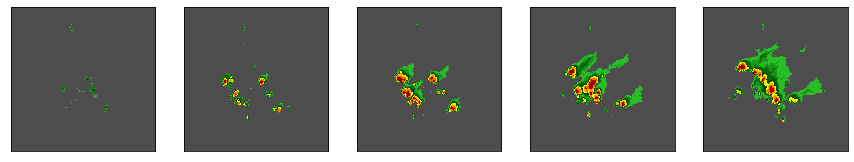

In [7]:
# View some frames
import matplotlib.pyplot as plt
from sevir.display import get_cmap
fig,axs=plt.subplots(1,5,figsize=(15,5))
cmap,norm,vmin,vmax = get_cmap('vil')
for i in [0,10,20,30,40]:
    axs[i//10].imshow( X[0][0,:,:,i],cmap=cmap,norm=norm,vmin=vmin,vmax=vmax)
    axs[i//10].set_xticks([], [])
    axs[i//10].set_yticks([], [])
# if you want US state lines, you need basemap or some other catographic library.  

In [8]:
# Close object
# this is a good idea so you don't leave the HDF file handles open
vil_seq.close()

#### Get multiple data types

In [9]:
# Look at IR satellite, Lightning counts, and Weather Radar (VIL)
# Treat IR + LGHT as the "input", vil and the target
vil_ir_lght_seq = SEVIRSequence(x_img_types=['ir107','lght'],y_img_types=['vil'],batch_size=4)

Opening HDF5 file for reading lght/2018/SEVIR_LGHT_ALLEVENTS_2018_0201_0301.h5
Opening HDF5 file for reading lght/2018/SEVIR_LGHT_ALLEVENTS_2018_0301_0401.h5
Opening HDF5 file for reading lght/2018/SEVIR_LGHT_ALLEVENTS_2018_0401_0501.h5
Opening HDF5 file for reading lght/2018/SEVIR_LGHT_ALLEVENTS_2018_0501_0601.h5
Opening HDF5 file for reading lght/2018/SEVIR_LGHT_ALLEVENTS_2018_0601_0701.h5
Opening HDF5 file for reading lght/2018/SEVIR_LGHT_ALLEVENTS_2018_0701_0801.h5
Opening HDF5 file for reading lght/2018/SEVIR_LGHT_ALLEVENTS_2018_0801_0901.h5
Opening HDF5 file for reading lght/2018/SEVIR_LGHT_ALLEVENTS_2018_0901_1001.h5
Opening HDF5 file for reading lght/2018/SEVIR_LGHT_ALLEVENTS_2018_1001_1101.h5
Opening HDF5 file for reading lght/2018/SEVIR_LGHT_ALLEVENTS_2018_1101_1201.h5
Opening HDF5 file for reading lght/2018/SEVIR_LGHT_ALLEVENTS_2018_1201_0101.h5
Opening HDF5 file for reading lght/2019/SEVIR_LGHT_ALLEVENTS_2019_0101_0201.h5
Opening HDF5 file for reading lght/2019/SEVIR_LGHT_A

In [10]:
# generate an X,Y pair
X,Y = vil_ir_lght_seq.__getitem__(420)  # X,Y are lists same length as x_img_types and y_img_types

In [11]:
print('X (IR):',X[0].shape)
print('X (LGHT):',X[1].shape)
print('Y (VIL):',Y[0].shape)

X (IR): (4, 192, 192, 49)
X (LGHT): (4, 48, 48, 48)
Y (VIL): (4, 384, 384, 49)


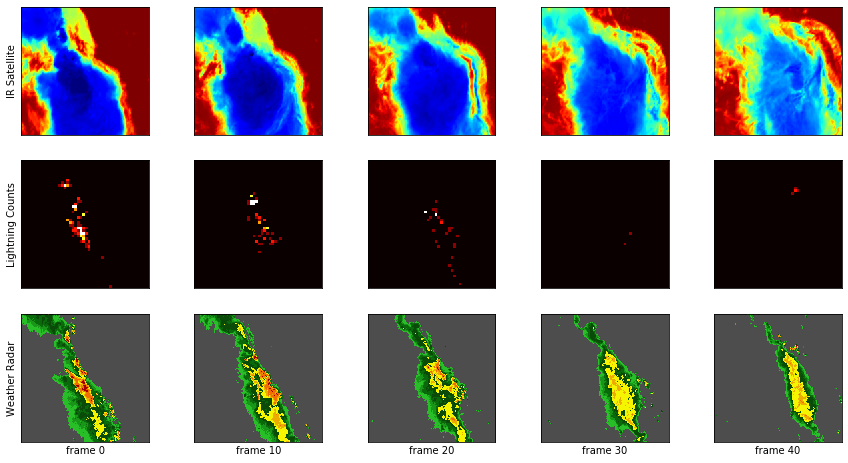

In [12]:
# View these
fig,axs=plt.subplots(3,5,figsize=(15,8))
cmap1,norm1,vmin1,vmax1 = get_cmap('ir107')
cmap2,norm2,vmin2,vmax2 = get_cmap('vil')
for i in [0,10,20,30,40]:
    axs[0][i//10].imshow( X[0][0,:,:,i]/100,cmap=cmap1,norm=norm1,vmin=vmin1,vmax=vmax1)
    axs[0][i//10].set_xticks([], [])
    axs[0][i//10].set_yticks([], [])
    if i==0:axs[0][i//10].set_ylabel('IR Satellite')
        
    axs[1][i//10].imshow( X[1][0,:,:,i],cmap='hot',vmin=0,vmax=5)
    axs[1][i//10].set_xticks([], [])
    axs[1][i//10].set_yticks([], [])
    if i==0:axs[1][i//10].set_ylabel('Lightning Counts')
    
    axs[2][i//10].imshow( Y[0][0,:,:,i],cmap=cmap2,norm=norm2,vmin=vmin2,vmax=vmax2)
    axs[2][i//10].set_xticks([], [])
    axs[2][i//10].set_yticks([], [])
    if i==0:axs[2][i//10].set_ylabel('Weather Radar')
    axs[2][i//10].set_xlabel(f'frame {i}')

In [13]:
vil_ir_lght_seq.close()

#### Get single images (not movies)

In [14]:
# Can also "unwrap" the time dimension if you only want single images
# Because of this, we'll increase batch size and also shuffle so that images in a movie don't appear next
# to each other in the batches
vil_imgs = SEVIRSequence(x_img_types=['vil'],
                         batch_size=256,
                         unwrap_time=True,
                         shuffle=True)

Opening HDF5 file for reading vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0501_0831.h5
Opening HDF5 file for reading vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0901_1231.h5
Opening HDF5 file for reading vil/2017/SEVIR_VIL_STORMEVENTS_2017_0101_0630.h5
Opening HDF5 file for reading vil/2017/SEVIR_VIL_STORMEVENTS_2017_0701_1231.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0101_0430.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0501_0831.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0901_1231.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_STORMEVENTS_2018_0101_0630.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_STORMEVENTS_2018_0701_1231.h5
Opening HDF5 file for reading vil/2019/SEVIR_VIL_RANDOMEVENTS_2019_0101_0430.h5
Opening HDF5 file for reading vil/2019/SEVIR_VIL_RANDOMEVENTS_2019_0501_0831.h5
Opening HDF5 file for reading vil/2019/SEVIR_VIL_RANDOMEVENTS_2019_0901_1231.h5
Opening HDF5 file for reading vil/2019/SEVIR

In [15]:
# Get a batch
X = vil_imgs.__getitem__(1234)  # returns list the same size as x_img_types passed to constructor
X[0].shape # Now there is no time dimension

(256, 384, 384, 1)

In [16]:
vil_imgs.close()

#### Date filters

When doing train/test splits, spliting on date of the event is a natural way partition your data.  This can be done easily in SEVIR by adding some date filters to the constructor

In [17]:
import datetime
# Train on 2018 data, test on 2019 data
vil_img_train = SEVIRSequence(x_img_types=['vil'],batch_size=256,unwrap_time=True,
                              start_date=datetime.datetime(2018,1,1),
                              end_date=datetime.datetime(2019,1,1))
vil_img_test = SEVIRSequence(x_img_types=['vil'],batch_size=256,unwrap_time=True,
                              start_date=datetime.datetime(2019,1,1),
                              end_date=datetime.datetime(2020,1,1))

Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0101_0430.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0501_0831.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0901_1231.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_STORMEVENTS_2018_0101_0630.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_STORMEVENTS_2018_0701_1231.h5
Opening HDF5 file for reading vil/2019/SEVIR_VIL_RANDOMEVENTS_2019_0101_0430.h5
Opening HDF5 file for reading vil/2019/SEVIR_VIL_RANDOMEVENTS_2019_0501_0831.h5
Opening HDF5 file for reading vil/2019/SEVIR_VIL_RANDOMEVENTS_2019_0901_1231.h5
Opening HDF5 file for reading vil/2019/SEVIR_VIL_STORMEVENTS_2019_0101_0630.h5
Opening HDF5 file for reading vil/2019/SEVIR_VIL_STORMEVENTS_2019_0701_1231.h5


In [18]:
del(vil_img_train)
del(vil_img_test)

In [19]:
# The datetime_filter can let you carefully control what times are sampled.
vis_seq = SEVIRSequence(x_img_types=['vis'],batch_size=32,unwrap_time=True,
                              start_date=datetime.datetime(2018,1,1),
                              end_date=datetime.datetime(2019,1,1),
                              datetime_filter=lambda t: np.logical_and(t.dt.hour>=13,t.dt.hour<=21))

Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0111_0120.h5
Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0121_0131.h5
Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0201_0210.h5
Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0211_0220.h5
Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0221_0228.h5
Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0301_0310.h5
Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0311_0320.h5
Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0321_0331.h5
Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0401_0410.h5
Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0411_0420.h5
Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0421_0430.h5
Opening HDF5 file for reading vis/2018/SEVIR_VIS_RANDOMEVENTS_2018_0501_0510.h5
Opening HDF5 file for reading vis/2018/S

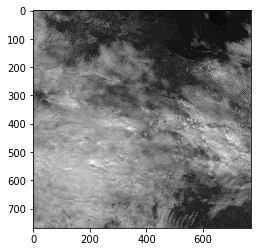

In [20]:
# images should all have day light for VIS satellite
X=vis_seq.__getitem__(123)
cmap,norm,vmin,vmax = get_cmap('vis')
plt.imshow(X[0][0,:,:,0]/10000,cmap=cmap,norm=norm,vmin=vmin,vmax=vmax)

In [21]:
vis_seq.close()

### Load several batches at once

The `SEVIRSequence` class can also be used to preload several batches at once. This makes sense if you have enough memory. This makes model training much faster since you are avoiding repeated data reads from disk.

In [22]:
import datetime
vil_gen = SEVIRSequence(x_img_types=['vil'],batch_size=256,unwrap_time=True,
                        start_date=datetime.datetime(2018,1,1),
                        end_date=datetime.datetime(2019,1,1))

Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0101_0430.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0501_0831.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_RANDOMEVENTS_2018_0901_1231.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_STORMEVENTS_2018_0101_0630.h5
Opening HDF5 file for reading vil/2018/SEVIR_VIL_STORMEVENTS_2018_0701_1231.h5


In [23]:
# Load 10 batches at once
X = vil_gen.load_batches(n_batches=10,progress_bar=True)

100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


In [24]:
X[0].shape  # should have 256 * 10 samples

(2560, 384, 384, 1)

# Using SEVIR in model training

See ModelTraining notebook